![GPT-Moliere Banner](https://openfileserver.chloelavrat.com/workshops/RadioGPT/assets/gpt-moliere-banner.png)



> 💡 **PLEASE CONNECT USING A GPU SESSION FOR MORE COMPUTE POWER** :
>
> `Runtime > Change runtime type > T4 GPU > Save`



# 🎯 Objective


The goal of this first notebook is to introduce you to the foundational concepts of training a language model. By working with a Molière dataset, you will experience:
- How text data is prepared for training a GPT model.
- The mechanics of training a model (tokenization, loss minimization, etc.).
- How the model starts to “learn” patterns and styles of a specific author.
- The magic of seeing the model generate text in Molière’s signature style after training.

By the end of this phase, participants will have trained your custom GPT model on Molière’s texts and understood key steps in the process. 🥳


# 🌱 Plan and key concepts

Language Models learn by analyzing patterns in unstructured text, like a book or script. Even if the text is just a plain file, the model extracts:

- **Word relationships:** Which words often appear together.
- **Context:** How meaning changes based on surroundings.
- **Style:** Sentence flow and unique phrasing.

So, why Molière? Molière’s rich vocabulary and poetic style make his works perfect for showcasing how models learn patterns like dramatic dialogues or 17th-century phrasing—all from unstructured text.

>💡 Imagine you were dropped in a foreign country and had to learn the language just by listening and reading signs. No one gives you a grammar book—you learn by spotting patterns over time. That’s exactly what our model does!

# 🛠️ Behind the Scenes of a GPT Model

## 🛠️ The dataset



The database is an adapted version of the [Moliere's db](https://huggingface.co/datasets/FrancophonIA/Moliere) where all column and texts has been glued together in order to have a single simple text that regroup all Molière's works.

In [1]:
# Download Moliere dataset
!mkdir dataset
!wget https://openfileserver.chloelavrat.com/workshops/RadioGPT/dataset/petitmoliere.txt -O dataset/petitmoliere.txt

mkdir: cannot create directory ‘dataset’: File exists
--2024-12-14 18:05:08--  https://openfileserver.chloelavrat.com/workshops/RadioGPT/dataset/petitmoliere.txt
Resolving openfileserver.chloelavrat.com (openfileserver.chloelavrat.com)... 149.202.72.149
Connecting to openfileserver.chloelavrat.com (openfileserver.chloelavrat.com)|149.202.72.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2226653 (2.1M) [text/plain]
Saving to: ‘dataset/petitmoliere.txt’

dataset/petitmolier 100%[===================>]   2.12M  3.75MB/s    in 0.6s    

2024-12-14 18:05:09 (3.75 MB/s) - ‘dataset/petitmoliere.txt’ saved [2226653/2226653]



In [2]:
# load the dataset file
with open("dataset/petitmoliere.txt") as f:
    petitmoliere = f.read()
print(petitmoliere[:99])

L AURORE:
Quand l’Amour à vos yeux offre un choix agréable,
Jeunes beautés laissez-vous enflammer.



Here we are the data is now loaded in memory let's continue ! :D

## 🔗 Tokenization

We need to transform input characters into numerical representations called tokens. This process involves using an embedding that assigns each character a unique numeric value. The simplest approach is to map characters directly to integers, similar to ASCII encoding, but with a custom character table designed specifically for our needs.

Note that we can have different type of tokenization. For example, for the sentence "hello world"
1. **Character level :** `["h", "e", "l", "l", "o", " ", "w", "o", "r", "l", "d"]`
2. **Word level :** `["hello", " ", "world"]`
3. **Subword level :** `["hel", "lo", " ", "wor", "ld"]`

In [3]:
# So let's tokenize Molière !
characters = sorted(list(set(petitmoliere)))
char_to_int = { char:i for i,char in enumerate(characters) }
int_to_char = { i:char for i,char in enumerate(characters) }

# display tokens
print("Characters      :"+"".join(characters)[1:]) #the first characters is a line break
print("Vocabulary size :", len(characters))

Characters      : !"'(),-.0123456789:;?ABCDEFGHIJLMNOPQRSTUVXYZ[]abcdefghijlmnopqrstuvxyz«­°º»ÀÂÆÇÈÉÊÎÔàâæçèéêëìíîïñòôùûüœ‑’
Vocabulary size : 108


In [4]:
def encode(x):
    """Encode text to integers."""
    return [char_to_int[char] for char in x]

def decode(x):
    """Decode integers to text."""
    return ''.join([int_to_char[i] for i in x])

msg = 'Bonjour Molière'
print("Message    : ", msg)
print("Embedding  : ", encode(msg))
print("Decodage   : ", decode(encode(msg)))

Message    :  Bonjour Molière
Embedding  :  [24, 62, 61, 58, 62, 68, 65, 1, 34, 62, 59, 57, 91, 65, 53]
Decodage   :  Bonjour Molière


As you can imagine this is not very optimized as the model will have to manage every letters as an entry. To avoid to send to much information to the model and as you get how things works, we will use a bre build encore that is working at a Subword level. This encoder will be used in the rest of the workshop.

In [5]:
!pip install tiktoken  > /dev/null 2>&1
import tiktoken
tokenizer = tiktoken.encoding_for_model("gpt-2")

msg = "Bonjour Molière"
print("Vocabulary size :", tokenizer.n_vocab)
print(f"Message        :", msg)
print(f"Embedding      : {tokenizer.encode(msg)}")
print(f"Refering to    : {[tokenizer.decode([t]) for t in tokenizer.encode(msg)]}")
print(f"Decodage       : {tokenizer.decode(tokenizer.encode(msg))}")

Vocabulary size : 50257
Message        : Bonjour Molière
Embedding      : [20682, 73, 454, 337, 11106, 35979]
Refering to    : ['Bon', 'j', 'our', ' M', 'oli', 'ère']
Decodage       : Bonjour Molière


As you can see we have a larger vocabulary but a smaller embedding :)  

## 📍 Positional Encoddings



When training a Transformer-based model like GPT, the model doesn't inherently understand the order of words in a sentence. However, word order is crucial for determining context and meaning. For example, in the sentence:

> "The cat chased the mouse,"

The order of words tells us who is chasing whom.

Since Transformers process all words simultaneously (in parallel), they need a way to encode the position of each word in the sequence. This is where **positional encodings** come into play.

Each token (or "subword") in the sentence is associated with a position value. The first position always gets the same value, the second position gets another, and so on. After applying positional encoding, we end up with two arrays: one for the words and one for their respective positions.

**Why is this necessary?**

The main reason is that Transformers process words in parallel and don’t have an innate sense of their order. To solve this, we use sine and cosine functions because they create smooth and unique patterns for each position, allowing the model to differentiate word positions.

Mathematically, this can be represented as:

$$
PE(pos, 2i) = \sin\left(\frac{pos}{10000^{2i/d}} \right)\\
PE(pos, 2i+1) = \cos\left(\frac{pos}{10000^{2i/d}} \right)
$$

This results in positional encodings that look like this:

![Positional Embedding](https://openfileserver.chloelavrat.com/workshops/RadioGPT/assets/positional_embedding.png)

In [6]:
# positional encoding function
import torch
import math

def positional_encoding(seq_len, d_model):
    """
    Compute sinusoidal positional encodings for a sequence.

    Args:
        seq_len (int): Length of the sequence.
        d_model (int): Dimension of the model (embedding size).

    Returns:
        torch.Tensor: A tensor of shape (seq_len, d_model) containing positional encodings.
    """
    position = torch.arange(0, seq_len).unsqueeze(1)  # Shape: (seq_len, 1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

    pe = torch.zeros(seq_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)  # Apply sine to even indices
    pe[:, 1::2] = torch.cos(position * div_term)  # Apply cosine to odd indices

    return pe

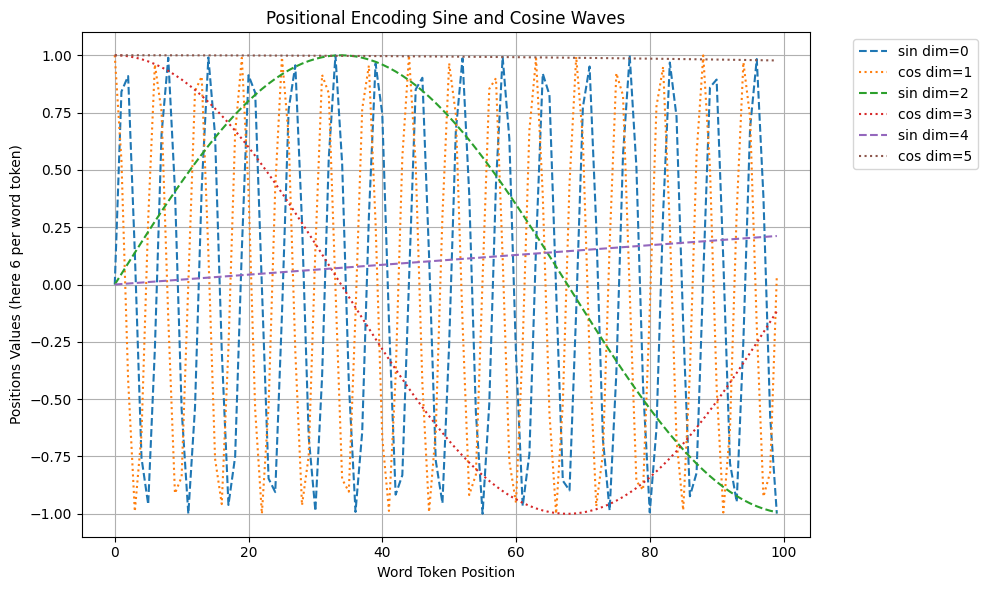

In [7]:
# positional encoding visualization
import matplotlib.pyplot as plt

max_position = 100  # Increased number of positions to see more oscillations
d_model = 6          # Reduced dimensions to make the plot clearer

# Generate positional embeddings for the sequence
positional_embeddings = positional_encoding(max_position, d_model)

plt.figure(figsize=(10, 6))
for i in range(d_model//2):
    plt.plot(positional_embeddings[:, 2*i],
             label=f'sin dim={2*i}', linestyle='--')
    plt.plot(positional_embeddings[:, 2*i+1],
             label=f'cos dim={2*i+1}', linestyle=':')

plt.title("Positional Encoding Sine and Cosine Waves")
plt.xlabel("Word Token Position")
plt.ylabel(f"Positions Values (here {d_model} per word token)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
msg = "Bonjour Molière"
tokens = tokenizer.encode(msg)
print(f"Message        :", msg)
print(f"Embedding txt  : {tokens}")
print(f"Refering to    : {[tokenizer.decode([t]) for t in tokenizer.encode(msg)]}")
print(f"Embedding pos  : \n{positional_encoding(len(tokens), 4)}")

Message        : Bonjour Molière
Embedding txt  : [20682, 73, 454, 337, 11106, 35979]
Refering to    : ['Bon', 'j', 'our', ' M', 'oli', 'ère']
Embedding pos  : 
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996],
        [-0.7568, -0.6536,  0.0400,  0.9992],
        [-0.9589,  0.2837,  0.0500,  0.9988]])


In practice, while sine and cosine positional encodings are elegant and mathematically grounded, we often use a simpler and more flexible approach: **an embedding layer**, like `nn.Embedding`.

This method allows the model to learn the positional information directly from the data, rather than relying on a fixed formula. Additionally, since we're training the model in a notebook environment, using `nn.Embedding` results in faster and more efficient training, allowing us to focus on the core aspects of the model rather than dealing with manual encoding calculations.

In [9]:
import torch
import torch.nn as nn

position_embedding_table = nn.Embedding(len(tokens), 4)

msg = "Bonjour Molière"
print(f"Message        :", msg)
print(f"Embedding txt  : {tokens}")
print(f"Embedding pos  : \n{position_embedding_table(torch.arange(len(tokens)))}")

Message        : Bonjour Molière
Embedding txt  : [20682, 73, 454, 337, 11106, 35979]
Embedding pos  : 
tensor([[-1.5902,  1.4283,  0.3648,  1.1648],
        [-0.7563, -0.1317, -1.0384, -0.6477],
        [ 0.8985,  0.7511, -0.7716,  0.9312],
        [-0.4652, -0.4424,  0.2434, -0.8640],
        [-2.0352,  0.5613, -0.6057, -0.5952],
        [-1.3717,  0.1680, -0.6012, -1.4635]], grad_fn=<EmbeddingBackward0>)


As the embedding layer is not trained yet (and fixed afetr training) you can see that if you re run the previous cell, you will have different values ☺️

## 📦 Batching

In this section, we’ll take the raw text dataset from Molière's plays and process it into manageable pieces for training our model. This step is crucial because large text datasets can be overwhelming for a model if fed all at once. So, **we’ll slice the data into smaller, equal-sized blocks (batches).**

These batches help the model focus on smaller sections of text at a time, making the training process more efficient. The key here is to ensure that each batch is small enough for the model to handle, but large enough to capture meaningful patterns and context.

As it is import to test the model on "unseen" data, we will split the dataset in 2 parts, one for training (90%) and one for evaluation (10%). The idea is to look during training is the model can perform and generalize on unseen data.

In [10]:
petitmoliere_tokens = tokenizer.encode(petitmoliere)

# use 90% of your dataset to train the model
n = int(0.9*len(petitmoliere_tokens))
train_data, valid_data = petitmoliere_tokens[:n], petitmoliere_tokens[n:]

# convert to tensor for ease of use
train_data = torch.tensor(train_data)
valid_data = torch.tensor(valid_data)

In [11]:
def get_batch(data, batch_size, block_size):
  # add a random offsets
  ix = torch.randint(len(data) - block_size, (batch_size,))
  # get subsequences, as data and target
  x_orig = torch.stack([data[i:i + block_size] for i in ix])
  # target is just shifted to the right
  x_target = torch.stack([data[i + 1:i + 1 + block_size] for i in ix])
  return x_orig, x_target

batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 3 # what is the maximum context length for

x_orig, x_target = get_batch(train_data, batch_size, block_size)
print('inputs:')
print(x_orig)
print('targets:')
print(x_target)

inputs:
tensor([[  198, 14772,    11],
        [   11,   288,   447],
        [   83,   627,   567],
        [42392,   518,   333]])
targets:
tensor([[14772,    11,  8591],
        [  288,   447,   247],
        [  627,   567,  6051],
        [  518,   333,  2162]])


## 🧠 GPT-model

**GPT (Generative Pre-trained Transformer)** is a groundbreaking Transformer architecture, specifically designed for tasks like text generation. Its strength lies in its modular design, where **a single GPT block forms the building block of the entire model**. These blocks are stacked repeatedly to create deep, powerful networks capable of capturing complex patterns in language.  

Let’s explore the components of a GPT block:  

- **Tokenization:** Converts raw text into numerical tokens, enabling the model to process and learn from language.  
- **Positional Embedding:** Assigns positional context to tokens, ensuring the model captures the order of words.  
- **Attention Mechanism:** The self-attention mechanism identifies relationships and dependencies between tokens across the sequence.  
- **Feedforward Layers:** Non-linear transformations refine the intermediate outputs for richer learning.  
- **Layer Normalization:** Ensures stable and efficient training by normalizing outputs within the block.  

The real power of GPT comes from **stacking multiple GPT blocks**. Each block processes the input, refines its understanding, and passes its output to the next block. This repetition allows the model to learn hierarchical representations and handle complex dependencies in text effectively.

Below is a visual representation of the GPT architecture, highlighting the modular and repetitive nature of its design:  

![](https://openfileserver.chloelavrat.com/workshops/RadioGPT/assets/gpt-archi.png)  

Now, let’s dive into each element of the GPT block to understand how they work together to achieve such impressive capabilities.

## ✨ Attention Mechanism

The **Attention Mechanism** is at the heart of the GPT architecture, enabling the model to focus on different parts of the input sequence when making predictions. Unlike traditional models that process inputs in a fixed, linear manner, attention allows the model to selectively "attend" to various parts of the input, regardless of their position in the sequence. This helps the model capture long-range dependencies and context, which is especially important for tasks like text generation.

**How Attention Works**

In simple terms, the attention mechanism looks at each token in the sequence and decides how much attention each other token should get. This is done using a concept called **self-attention**. For each token, self-attention computes a weighted sum of all other tokens in the sequence, where the weights determine how much influence each token has on the current token.

There are three main components in the attention mechanism:

- **Query (Q):** Represents the token that is asking for attention.
- **Key (K):** Represents the tokens that can be attended to.
- **Value (V):** Represents the information that is being passed along based on the attention score.

The attention mechanism computes a score that tells how much focus should be placed on other tokens, and then the values of the tokens are weighted accordingly.

**Attention Formula**

The attention score between a query and a key is calculated using the following formula:
$$
\text{Attention Score} = \frac{Q \cdot K^T}{\sqrt{d_k}}
$$

Where:
- (Q) is the query vector.
- (K) is the key vector.
- ($d_k$) is the dimensionality of the key vector, used for scaling.

Then, the attention scores are passed through a [softmax function](https://en.wikipedia.org/wiki/Softmax_function) to normalize them, and this gives us the attention weights.

Finally, the weighted sum of the values (V) is computed:

$$
\text{Attention Output} = \text{softmax}(Q \cdot K^T / \sqrt{d_k}) \cdot V
$$

This output is what the model uses to update its understanding of the input sequence.

Let’s look at a simple Python implementation to understand how attention works using NumPy. We’ll simulate the attention mechanism with arbitrary values for the query, key, and value matrices.


In [12]:
import numpy as np

# Simulating query (Q), key (K), and value (V) matrices
np.random.seed(42)  # For reproducibility

# Let's say our input sequence has 3 tokens: "the", "cat", "sat" of 4-dimensional
Q = np.random.rand(3, 4)  # 3 tokens, 4-dimensional query vectors
K = np.random.rand(3, 4)  # 3 tokens, 4-dimensional key vectors
V = np.random.rand(3, 4)  # 3 tokens, 4-dimensional value vectors

# Step 1: Calculate the dot product of Q and K^T (transpose of K)
QK_T = np.dot(Q, K.T)

# Step 2: Scale the dot product by the square root of the dimension of the key vectors
d_k = K.shape[1]
scaled_QK_T = QK_T / np.sqrt(d_k)

# Step 3: Apply softmax to the scaled attention scores to get the attention weights
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

attention_weights = softmax(scaled_QK_T)

# Step 4: Calculate the weighted sum of the values (V) using the attention weights
attention_output = np.dot(attention_weights, V)

print("Attention Weights:\n", attention_weights)
print("Attention Output:\n", attention_output)

Attention Weights:
 [[0.31164829 0.37066075 0.31769096]
 [0.32266579 0.33486977 0.34246444]
 [0.33283257 0.33507568 0.33209175]]
Attention Output:
 [[0.38238456 0.56336845 0.59419359 0.48028741]
 [0.36781777 0.59386381 0.59857094 0.49987658]
 [0.37190176 0.5920136  0.59070988 0.49675455]]



1. **Query, Key, and Value Matrices**: These are random matrices that represent the query, key, and value vectors for each token in a sequence. In practice, these vectors are learned during training.
   
2. **Dot Product**: The dot product between the query and the transpose of the key is calculated. This gives us a score that indicates how much focus the query should place on each token in the sequence.

3. **Scaling**: To prevent large values in the dot product from affecting the model’s training stability, we scale the scores by the square root of the key vector's dimension $\sqrt{d_k}$.

4. **Softmax**: The softmax function is applied to the attention scores to normalize them. The softmax function ensures that the attention weights are positive and sum to 1, making them interpretable as probabilities.

5. **Weighted Sum**: Finally, the attention weights are used to compute a weighted sum of the value vectors, which produces the attention output.

You can think of this mechanism as a way to allow each token in the sequence to "pay attention" to other tokens, depending on how relevant they are. The softmaxed attention weights can be visualized as a heatmap, where higher values indicate stronger attention.

Here’s an example heatmap showing attention weights between tokens:


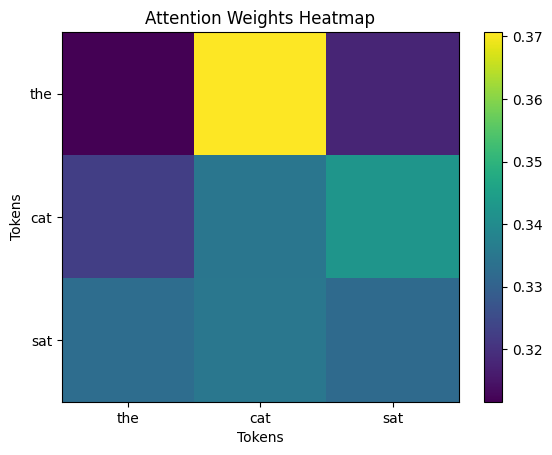

In [13]:
# Visualizing the attention weights with a heatmap:
import matplotlib.pyplot as plt
plt.imshow(attention_weights, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Attention Weights Heatmap")
plt.xlabel("Tokens")
plt.ylabel("Tokens")
plt.xticks(np.arange(3), ["the", "cat", "sat"])  # Label the x-axis
plt.yticks(np.arange(3), ["the", "cat", "sat"])  # Label the y-axis
plt.show()


This heatmap helps visualize how each token’s attention is distributed across the other tokens in the sequence.

The attention mechanism is what allows GPT models to focus on important parts of the input, capturing long-range dependencies in language. By using a weighted sum of the value vectors, the model dynamically adjusts its focus on different tokens in the sequence, enabling it to generate coherent and contextually rich text.

> 💡 **THIS IS NOT A TRAINED ATTENTION HEAT MAP SO YOU CAN'T INTERPRET IT YET**

## 🎛️ Feed Forward

After the attention mechanism has refined the representation of each token in the sequence, the next key component in the GPT block is the **Feedforward Layer**. This layer applies non-linear transformations to each token’s representation, further enriching its features and allowing the model to capture more complex patterns. While the attention mechanism focuses on dependencies between tokens, the feedforward layers help the model learn more abstract and high-level patterns in the data.

**What Do Feedforward Layers Do?**

Feedforward layers are made up of **fully connected neural network layers** that process each token independently. This is different from the attention mechanism, which considers the entire sequence when updating the token’s representation. Feedforward layers help refine the token embeddings by applying transformations that increase the expressive power of the model.

Each feedforward layer typically consists of two main parts:

1. **Linear Transformation (Dense Layer):** Applies a learned linear transformation (weights and biases) to the input token representation.
2. **Non-linear Activation Function:** Introduces non-linearity to the transformation, allowing the model to capture more complex relationships in the data. Common activation functions are **ReLU** (Rectified Linear Unit) or **GELU** (Gaussian Error Linear Unit) in modern architectures like GPT.

The feedforward layer operates **independently on each token**, which means the transformation is applied to every token’s representation separately, without considering other tokens in the sequence.

**Feedforward Layer Formula**

The feedforward layer can be represented by the following formula:

$$
\text{FFN}(x) = \text{max}(0, xW_1 + b_1)W_2 + b_2
$$

Where:
- ($x$) is the input token representation.
- ($W_1$), ($W_2$) are weight matrices.
- ($b_1$), ($b_2$) are bias terms.
- The activation function $\text{max}(0, x)$ represents ReLU or other activation functions like GELU.

Let’s implement a simple feedforward layer using PyTorch. In this example, we'll apply a two-layer feedforward neural network to a token’s representation.

In [14]:
import torch
import torch.nn as nn

# Simulating a token embedding (3 tokens, 4-dimensional feature vector)
tokens = torch.rand(3, 4)  # 3 tokens, 4 features

# Define a simple feedforward neural network (2 layers)
class FeedForwardLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForwardLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First linear layer
        self.activation = nn.ReLU()  # Non-linear activation
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Second linear layer

    def forward(self, x):
        x = self.fc1(x)  # Apply first linear transformation
        x = self.activation(x)  # Apply activation function
        x = self.fc2(x)  # Apply second linear transformation
        return x

# Create a feedforward layer with input dimension 3, hidden dimension 5, and output dimension 3
feedforward_layer = FeedForwardLayer(input_dim=4, hidden_dim=5, output_dim=4)

# Pass the token embeddings through the feedforward layer
output = feedforward_layer(tokens)

print("Feedforward Layer Output:\n", output)

Feedforward Layer Output:
 tensor([[-0.1035,  0.0136, -0.3507, -0.3904],
        [-0.1752,  0.0812, -0.2472, -0.2658],
        [-0.2231,  0.0219, -0.3156, -0.3129]], grad_fn=<AddmmBackward0>)


1. **Token Embedding:** We simulate a sequence of tokens, each represented by a 3-dimensional feature vector (for simplicity, we use random values).

2. **Feedforward Layer Definition:** We define a simple feedforward neural network with two layers:
   - **First Linear Layer (`fc1`)**: Transforms the input from a 4-dimensional vector to a higher-dimensional 5-dimensional vector.
   - **Activation (`ReLU`)**: Applies a non-linear transformation to introduce non-linearity.
   - **Second Linear Layer (`fc2`)**: Projects the 4-dimensional representation back down to a 3-dimensional vector, similar to the input token representation.

3. **Forward Pass:** We apply the feedforward network to each token independently, resulting in transformed token representations.

**Visualizing the Feedforward Layer**

The feedforward layer processes each token’s representation independently, so if we visualize the input and output of the layer, we would see how the embeddings are transformed at each step. You can think of this transformation as adding more "depth" to the model’s understanding of each token.

Here's a simple visualization of token transformations using a bar plot:


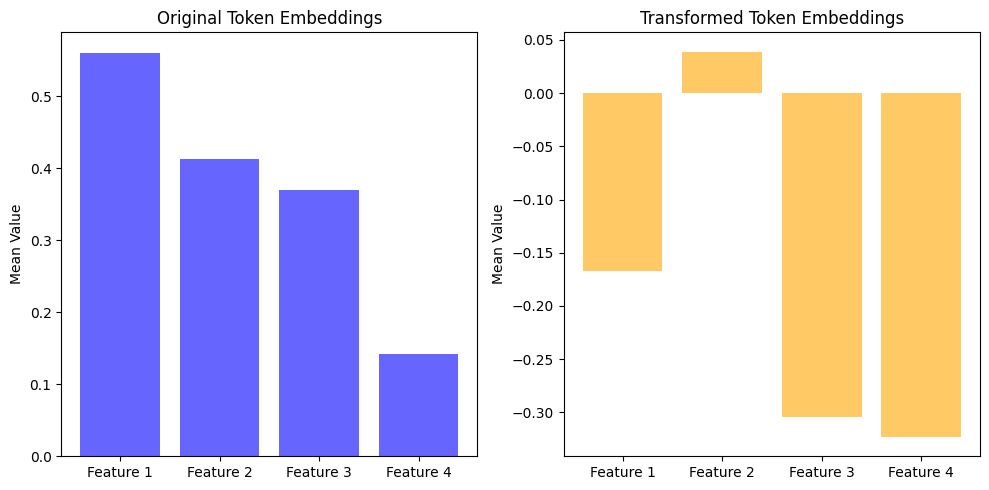

In [15]:
import matplotlib.pyplot as plt

# Visualizing the transformation of the token embeddings before and after feedforward layer
tokens_np = tokens.detach().numpy()  # Convert to numpy for plotting
output_np = output.detach().numpy()

plt.figure(figsize=(10, 5))

# Plot original token embeddings
plt.subplot(1, 2, 1)
plt.bar(range(4), tokens_np.mean(axis=0), color='blue', alpha=0.6, label="Input Embeddings")
plt.title("Original Token Embeddings")
plt.xticks(range(4), [f"Feature {i+1}" for i in range(4)])
plt.ylabel("Mean Value")

# Plot output token embeddings
plt.subplot(1, 2, 2)
plt.bar(range(4), output_np.mean(axis=0), color='orange', alpha=0.6, label="Output Embeddings")
plt.title("Transformed Token Embeddings")
plt.xticks(range(4), [f"Feature {i+1}" for i in range(4)])
plt.ylabel("Mean Value")

plt.tight_layout()
plt.show()

The visualization compares the mean values of the token embeddings before and after the feedforward transformation.

In the **original embeddings**, the mean values are positive due to the initialization of the embeddings. After the **feedforward transformation**, the mean values can be both positive and negative. This happens because the **ReLU activation** clips negative values during the first linear transformation, but the second linear transformation can produce both positive and negative values, leading to a wider range in the output embeddings.

# ⛳️ GPT-Molière Training



In this section, **we’ll train a GPT model**, specifically a **lightweight** version of GPT. We will go through the key parameters involved in the model setup and training, so you can better understand how each component contributes to the process.

We begin by installing the necessary libraries for our model training process, which includes PyTorch for deep learning operations, Datasets for data loading, tqdm for progress bars, and Hugging Face's Transformers for model utilities.

For curious peoples, the GPT model's code can be found on my GitHub here: https://github.com/chloelavrat/RadioGPT

In [16]:
!git clone https://github.com/chloelavrat/RadioGPT.git > /dev/null 2>&1
!cd RadioGPT && git checkout clavrat/first-version > /dev/null 2>&1
!pip install torch datasets tqdm transformers > /dev/null 2>&1

Given that the model is parametric, it is necessary to define specific values for its various parameters to control its behavior and performance. These values determine how the model processes input sequences, manages memory, and learns token relationships. Below are the key parameters and their respective values:

1. **block_size (64)**
   The `block_size` sets the length of input sequences the model processes at once. With a value of 64, the model handles 64 tokens per sequence, which impacts context retention and memory requirements.

2. **n_embd (16)**
   `n_embd` is the dimensionality of token embeddings, representing each token as a 16-dimensional vector. A smaller value like 16 balances workshop efficiency with capturing basic token relationships for demonstration. (GPT-2 uses 768, GPT-3 uses 12,288 for the largest model).

3. **n_head (6)**
   `n_head` defines the number of attention heads in the self-attention mechanism. With 6 heads, the model can learn different aspects of token dependencies in parallel, improving its understanding of context.

4. **n_layer (10)**
   `n_layer` specifies the number of transformer layers in the model. With 10 layers, the model learns progressively complex patterns, while maintaining a reasonable computational cost.

5. **dropout (0.2)**
   `dropout` is a regularization technique to prevent overfitting. A rate of 0.2 means 20% of neurons are randomly dropped during training, encouraging the model to generalize better.

In [17]:
# Model parameters
block_size = 64
n_embd = 16
n_head = 6
n_layer = 10
dropout = 0.2

Then we can define some training parameters:
1. The **learning_rate** controls the size of weight updates during training. A small value like $0.001$ helps achieve stable and gradual convergence, but may slow down training.
1. **epochs** represents the number of times the model will iterate over the entire training dataset. A high value like 1000 ensures extensive training.
1. **batch_size** defines the number of training examples processed per step. A batch size of 128 strikes is the maximum we can feed into a T4 for this model 😲😅


In [18]:
# training parameters
learning_rate = 1e-3
epochs = 1000
batch_size = 128

We initialize the model by specifying the parameters. The **RadioGPT model** is designed with a smaller architecture for faster experimentation and experimentation

In [24]:
from RadioGPT.gptmodel.core.model import GPTlite

# Initialize model
device = (
    torch.device("mps") if torch.backends.mps.is_available() else
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("cpu")
)

config = {
    'context_size': block_size,
    'vocab_size': tokenizer.n_vocab,
    'embedding_dim': n_embd,
    'num_heads': n_head,
    'num_layers': n_layer,
    'dropout': dropout
}

model = GPTlite(config).to(device)

print(f"You will train on            {device}")

You will train on            cuda


This step ensures that the model is placed on the appropriate device (GPU if available, otherwise CPU).

In [25]:
# Get the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters   {total_params / 1e6:.1f}M")

Total number of parameters   1.7M


Our model has **1.7 million parameters (1.7M)**, which is considered quite small compared to larger GPT models like GPT-2 and GPT-3. Here's a quick comparison:

* **GPT-2 Small:** 117M parameters
* **GPT-2 Medium:** 345M parameters
* **GPT-2 Large:** 762M parameters
* **GPT-3:** 175B parameters

**The difference in scale can be illustrated as follows:**

- **Our model is roughly 69 times smaller than GPT-2 Small** (117M parameters).
- GPT-3, being 175 billion parameters, is about **103,000 times larger than our model !**

**Lets define the optimizer and scaler**

The optimizer will adjust the model’s parameters during training, and the GradScaler helps with mixed-precision training, improving efficiency.

1. The **optimizer** is responsible for updating the model's parameters (weights) based on the gradients calculated during backpropagation. In this case, we're using AdamW, which is a variation of the Adam optimizer with weight decay.

2. The **scaler** is used to manage mixed-precision training. In mixed-precision training, both 16-bit and 32-bit floating-point operations are used, which improves training efficiency without sacrificing model accuracy.

By using the optimizer and scaler together, we ensure that the model is efficiently trained with stable updates and optimized memory usage.

In [34]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Initialize the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1, betas=(0.9, 0.999))

# Initialize the scaler
scaler = torch.amp.GradScaler()

Here, Padawan, you have two paths to choose from:

1. **Training from Scratch:** If you have time and want to see the entire training process, you can proceed by training the model from the beginning. Simply skip the next cell, and you’ll be starting fresh!

2. **Using a checkpoint:** Running out of time but still want to see the model in action? Don’t worry, we've got your back! You can load a slightly pretrained version of the model (aka checkpoint), skipping the initial training phase and diving straight into the fun part. This will allow you to explore the model’s capabilities without waiting for the full training process.


Choose wisely, and let the training (or exploration) begin!

In [26]:
# Load RadioGPT's checkpoint :)
from RadioGPT.gptmodel.core.utils import load_model
import os, subprocess

os.makedirs("models", exist_ok=True)

print("Loading model...")
subprocess.run(["wget", "https://openfileserver.chloelavrat.com/workshops/RadioGPT/models/model_moliere.pth", "-O", "models/model_moliere.pth"])

model = load_model("models/model_moliere.pth", device, config)
model = model.to(device)
print("Model loaded !")

Loading model...
Model loaded !


![](https://openfileserver.chloelavrat.com/workshops/RadioGPT/assets/training-time-1.png)

Now we begin the training loop. This loop iterates over the dataset for a set number of epochs, updating the model parameters with each batch.

- `eval_loss`: This function evaluates the model on the validation dataset.
- `get_batch`: This function fetches the next batch of data for training`


In [ ]:
# Training setup
import torch
import torch.nn.functional as F
from tqdm import tqdm

print("Let's fry some eggs!! (your loss should be less than 5, restart cell if not...)")
print("-" * 5)

# Initialize optimizer and scaler
optimizer.zero_grad()

# Training loop with tqdm progress bar
pbar = tqdm(range(epochs), desc="Training", ncols=120)

for steps in pbar:
    # Evaluation loop
    @torch.no_grad()
    def eval_loss():
        # Get a batch of validation data
        idx, targets = get_batch(valid_data, batch_size, block_size)
        idx, targets = idx.to(device), targets.to(device)

        # Forward pass
        logits, loss = model(idx, targets)

        # Print evaluation loss on the right side of the tqdm bar
        pbar.set_postfix(eval_loss=f"{loss.item():.2f}")
        return loss

    # Get a batch of training data
    idx, targets = get_batch(train_data, batch_size, block_size)
    idx, targets = idx.to(device), targets.to(device)

    # Zero gradients
    optimizer.zero_grad()

    # Forward pass with automatic mixed precision
    with torch.cuda.amp.autocast():
        logits, loss = model(idx, targets)

    # Backward pass with gradient scaling
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # Update the tqdm description with loss value
    if steps % 100 == 0:
        pbar.write(f" Eval {eval_loss().item():.2f}")

    pbar.set_postfix(loss=f"{loss.item():.2f}")

**YOU DID IT! YOU TRAINED YOUR FIRST LLM**
> you can save your's with the folowing cell if you want 🎉🥳

In [36]:
# save RadioGPT model
from RadioGPT.gptmodel.core.utils import save_model
os.makedirs("models", exist_ok=True)
save_model(model)

Now that we've trained the model and fine-tuned it, it's time to see it in action! In the next section, we'll explore the magic of text generation, where we’ll use the model to create dialogues and sentences in the style of Molière. Get ready to unleash your creativity and see how the model brings literary characters to life!

# 🎨 Let's Play

In this section, we’ll walk through the process of generating text using the model we’ve trained. Specifically, we'll use the Molière dataset that we've prepared earlier to generate text in the style of the famous French playwright.

**Text Generation Steps:**

1. **Model Evaluation Mode:** We start by switching the model to evaluation mode using model.eval(). This is important because it tells the model not to update any parameters during the text generation, which is essential for generating consistent results.
1. **Tokenization:** The input text (the prompt) is tokenized, i.e., it's converted into a sequence of tokens that the model can understand. The tokenizer.encode(prompt) function does this transformation. The result is a tensor of token IDs, which is then passed to the model.
1. **Generation:** The model uses the generate method to predict the next tokens based on the input prompt. We set max_new_tokens=200, meaning the model will generate up to 200 new tokens after the prompt. This is where the magic happens — the model builds upon the initial input and starts generating coherent text.
1. **Decoding:** Once the model has generated a sequence of token IDs, the tokens are decoded back into readable text using tokenizer.decode(). This step translates the token IDs back into human-readable characters.
1. **Returning the Output:** Finally, we return only the newly generated text, excluding the prompt, so that we get just the continuation of the sentence or dialogue.

In [37]:
# LLM generation fonction
def generate_response(model, prompt, device, max_new_tokens=200):
    model.eval()
    # Encode the prompt
    input_tensor = tokenizer.encode(prompt)
    input_tensor = torch.tensor(input_tensor).unsqueeze(0).to(device)

    # Generate text using the model's generate method
    with torch.no_grad():
        generated_indices = model.generate(input_tensor, max_new_tokens)
        generated_text = tokenizer.decode(generated_indices[0].tolist())

    # Return only the newly generated part (after the prompt)
    return generated_text[len(prompt):]

Let’s generate some Molière-style dialogue with a simple prompt:

In [38]:
prompt = 'LYCISCAS:\n'
print(prompt+generate_response(model, prompt, device, max_new_tokens=50))

LYCISCAS:
Je vous parle de le Père.

Je vous,
ARELLE:
CELLE:
Ah !
Oui, un choses-ce,

Vous voir que vous avec


**Your Turn!**

Now it’s your turn to get creative! You can experiment with different prompts, character names, or even specific themes from Molière’s works to see how the model responds.

Example prompts to try:

- `ARMANE:`
- `SGARNARELLE:`
- `DONA ELVIRE:`

Feel free to play around and see how the model handles these different inputs!

In [39]:
prompt = 'ARMANE:' # @param {type:"string"}
max_new_tokens = 83 # @param {type:"slider", min:5, max:500, step:1}


prompt = prompt + '\n'
prompt = prompt + generate_response(model, prompt, device, max_new_tokens)
print(prompt)

ARMANE:
Séis-vous ;
Tout...

CLEANTE:
E:

Vous fautz rien.
Je suis dessein de me s’il veux aquans des, et d’a bien, sans quelque avez de la fessusque l’est-vous dit.
Non s’en


As you can see, the output generated by the model has some quirks and inconsistencies, which is expected given the model's current size. For example:

```
EURYALE:

Vous faut, il serété, je suis, et de cites,

Que l’est de t’est plus à vous vous déj:
Ne de je me faut vous vous dons de poule.

MASCARILLE:
Le vous ne vous m’ai, Monsieur.
```


These results can feel **somewhat disjointed and disconnected**, as the smaller model may struggle to maintain coherence over longer sequences. In the **next notebook**, we will load a larger model trained on a chat dataset, which should yield more natural and usable text. While the model size will still remain manageable for running on Colab, the results will be noticeably improved in terms of fluency and relevance.


# ⏩ Next Notebook please

![](https://openfileserver.chloelavrat.com/workshops/RadioGPT/assets/next-notebook-please-1.png)
